In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import requests
import random
import xlrd
import csv
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import matplotlib as mpl
import matplotlib.style
import seaborn as sns  
import matplotlib.pyplot as plt
# setting to default parameters
plt.rcParams.update(plt.rcParamsDefault)

# formatting for decimal places
pd.set_option("display.float_format", "{:.2f}".format)

sns.set_style("white")
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

# matplotlib settings
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-white')
mpl.rcParams["figure.figsize"] = (12, 8)
mpl.rcParams["axes.grid"] = False


In [2]:
# setting seed for model reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [3]:
def pre_process(df, column):
    df.drop("Unnamed: 0", axis=1, inplace=True)
    df.info()
    print(df.columns)
    # descriptive statistics
    df.describe().T
    df.head(15)
    df.nunique()    
    df.dtypes
    df.shape
    # filtering
    df.dropna(inplace=True)
    # drop rows where oil rate is 0
    df = df[(df[column].notnull()) & (df[column] > 0)]
    return df

def decline_curve(curve_type, q_i):
    if curve_type == "exponential":

        def exponential_decline(T, d):
            return q_i * np.exp(-d * T)
        return exponential_decline

    elif curve_type == "hyperbolic":

        def hyperbolic_decline(T, d_i, b):
            return q_i / np.power((1 + b * d_i * T), 1.0 / b)
        return hyperbolic_decline

    elif curve_type == "harmonic":

        def parabolic_decline(T, d_i):
            return q_i / (1 + d_i * T)
        return parabolic_decline

    else:
        raise "Unknown Decline Curve!"


def L2_norm(Q, Q_obs):
    return sqrt(mean_squared_error(Q, Q_obs))


In [4]:
train_prod = pd.read_csv('data/train_prod.csv')
test_prod = pd.read_csv("data/test_prod.csv")


train_prod = pre_process(train_prod, 'Oil')
test_prod = pre_process(test_prod, 'Oil')


train_prod["ReportDate"] = pd.to_datetime(train_prod["ReportDate"])
test_prod["ReportDate"] = pd.to_datetime(test_prod["ReportDate"])


grouped_data = train_prod.groupby(['API_WELLNO']).sum()
grouped_data = grouped_data.sort_values(by=['Oil'])
grouped_data = grouped_data.nlargest(10, 'Oil').reset_index()
example_wells = grouped_data['API_WELLNO'].to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684415 entries, 0 to 684414
Data columns (total 21 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ReportDate  684415 non-null  object 
 1   API_WELLNO  684415 non-null  float64
 2   FileNo      684415 non-null  float64
 3   Company     684415 non-null  object 
 4   WellName    684415 non-null  object 
 5   Quarter     684415 non-null  object 
 6   Section     684415 non-null  float64
 7   Township    684415 non-null  float64
 8   Range       684415 non-null  float64
 9   County      684415 non-null  object 
 10  FieldName   684415 non-null  object 
 11  Pool        684415 non-null  object 
 12  Oil         678599 non-null  float64
 13  Wtr         678599 non-null  float64
 14  Days        678599 non-null  float64
 15  Runs        684415 non-null  float64
 16  Gas         678599 non-null  float64
 17  GasSold     684415 non-null  float64
 18  Flared      678599 non-null  float64
 19  La

In [5]:
print (example_wells)
demo_well = [33053059210000, 33025021780000]


[3.30250262e+13 3.30530592e+13 3.30530565e+13 3.30530741e+13
 3.30530578e+13 3.30530592e+13 3.30530592e+13 3.30530592e+13
 3.30250218e+13 3.30550014e+13]


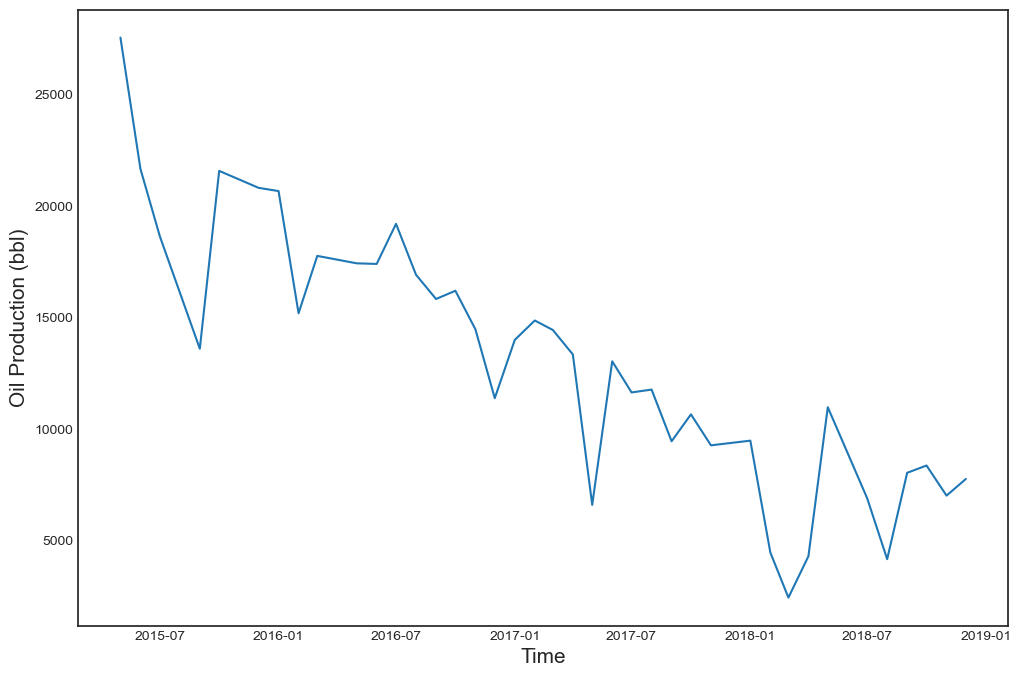

In [6]:
df_temp = train_prod[train_prod['API_WELLNO'] == example_wells[9]]
plt.plot(df_temp['ReportDate'],df_temp['Oil'].values)
df_temp['date_delta'] = (df_temp['ReportDate'] - df_temp['ReportDate'].min())/np.timedelta64(1,'D')
#plt.title('Decline Curve', fontsize = 20)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Oil Production (bbl)', fontsize = 15)
plt.show()

In [7]:
df_temp = df_temp[['date_delta', 'Oil']]
data = df_temp.to_numpy()
# T is number of days of production - cumulative
# q is production rate
T_train, q = data.T
print(T_train)
print(q)

[   0.   31.   61.  123.  153.  214.  245.  276.  305.  366.  397.  427.
  458.  489.  519.  550.  580.  611.  642.  670.  701.  731.  762.  792.
  823.  854.  884.  915.  976. 1007. 1035. 1066. 1096. 1127. 1157. 1188.
 1219. 1249. 1280. 1310.]
[27545. 21657. 18641. 13597. 21570. 20810. 20664. 15188. 17759. 17426.
 17398. 19195. 16913. 15827. 16196. 14469. 11381. 13992. 14863. 14438.
 13341.  6597. 13033. 11638. 11766.  9449. 10655.  9267.  9477.  4462.
  2442.  4295. 10975.  8904.  6898.  4164.  8035.  8362.  7013.  7760.]


In [8]:
# Assumption - determine qi from max value of first 3 months of production
df_initial_period = df_temp.head(3)
qi = df_initial_period['Oil'].max()

exp_decline = decline_curve("exponential", qi)
hyp_decline = decline_curve("hyperbolic", qi)
har_decline = decline_curve("harmonic", qi)

popt_exp, pcov_exp = curve_fit(exp_decline, T_train, q, method="trf")
popt_hyp, pcov_hyp = curve_fit(hyp_decline, T_train, q, method="trf")
popt_har, pcov_har = curve_fit(har_decline, T_train, q, method="trf")

print("RMSE of exponential decline: ", L2_norm(exp_decline(T_train, popt_exp[0]), q))
print("RMSE of hyperbolic decline decline: ",L2_norm(hyp_decline(T_train, popt_hyp[0], popt_hyp[1]), q))
print("RMSE of harmonic decline decline: ", L2_norm(har_decline(T_train, popt_har[0]), q))

RMSE of exponential decline:  13422.97648902802
RMSE of hyperbolic decline decline:  2905.158413445567
RMSE of harmonic decline decline:  2941.1450683376565


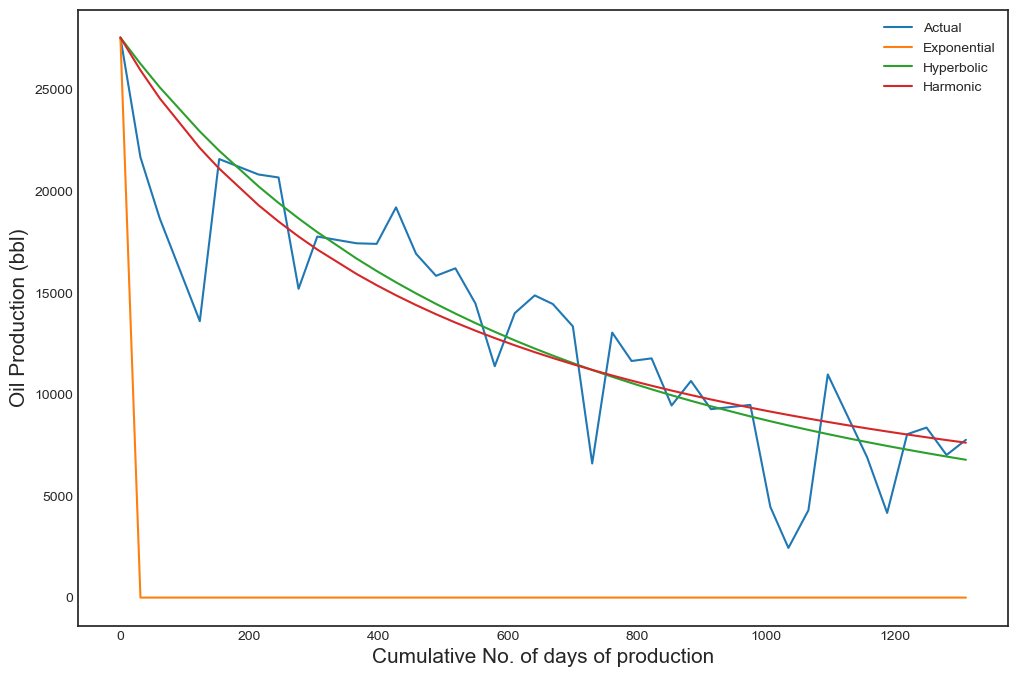

In [84]:
pred_exp = exp_decline(T_train, popt_exp[0])
pred_hyp = hyp_decline(T_train, popt_hyp[0], popt_hyp[1])
pred_har = har_decline(T_train, popt_har[0])
plt.plot(T_train, q,label="Actual",alpha=1)
plt.plot(T_train, pred_exp, label="Exponential")
plt.plot(T_train, pred_hyp, label="Hyperbolic"  )
plt.plot(T_train, pred_har, label="Harmonic"  )
plt.xlabel('Cumulative No. of days of production', fontsize = 15)
plt.ylabel('Oil Production (bbl)', fontsize = 15)
plt.legend(loc='best')
plt.show()

In [85]:
print('API:', example_wells[9])
df_temp_test = test_prod[test_prod['API_WELLNO'] == example_wells[9]]
df_temp_test['date_delta'] = (df_temp_test['ReportDate'] - df_temp_test['ReportDate'].min())  / np.timedelta64(1,'D')
print(df_temp_test)
df_temp_test = df_temp_test[['date_delta', 'Oil']]
data_test = df_temp_test.to_numpy()
# T is number of days of production - cumulative
# q is production rate
T_test, q_test = data_test.T

#T_test = np.concatenate(T_train, T)
print(T_test)
print(q_test)

API: 33055001360000.0
       ReportDate        API_WELLNO   FileNo             Company  \
5171   2019-01-01 33055001360000.00 19296.00  SHD OIL & GAS, LLC   
22588  2019-02-01 33055001360000.00 19296.00  SHD OIL & GAS, LLC   
40064  2019-03-01 33055001360000.00 19296.00  SHD OIL & GAS, LLC   
57613  2019-04-01 33055001360000.00 19296.00  SHD OIL & GAS, LLC   
75272  2019-05-01 33055001360000.00 19296.00  SHD OIL & GAS, LLC   
93048  2019-06-01 33055001360000.00 19296.00  SHD OIL & GAS, LLC   
110938 2019-07-01 33055001360000.00 19296.00  SHD OIL & GAS, LLC   
128957 2019-08-01 33055001360000.00 19296.00  SHD OIL & GAS, LLC   
147089 2019-09-01 33055001360000.00 19296.00  SHD OIL & GAS, LLC   
165324 2019-10-01 33055001360000.00 19296.00  SHD OIL & GAS, LLC   
183638 2019-11-01 33055001360000.00 19296.00  SHD OIL & GAS, LLC   
202082 2019-12-01 33055001360000.00 19296.00  SHD OIL & GAS, LLC   

              WellName Quarter  Section  Township  Range County  ...     Oil  \
5171    GOLDE

In [86]:
time = pd.date_range(start='6/1/2015', periods= 52, freq='MS')
time
T_Test2 = T_train[-1] + T_test
len(T_train)
pred_hyp =  hyp_decline(T_train, popt_hyp[0], popt_hyp[1])
pred_hyp2 = hyp_decline(T_Test2, popt_hyp[0], popt_hyp[1])
print(pred_hyp)
print(pred_hyp2)
# forecast
q_orig = np.append(q, q_test)
forecast = np.concatenate([pred_hyp, pred_hyp2])

[27545.         26257.23909802 25095.66995243 22928.32073985
 21979.7128467  20224.97106543 19413.17630788 18649.61157072
 17975.63751249 16672.82947492 16064.71008757 15507.54881798
 14961.92321827 14444.7841813  13969.6070034  13502.96848331
 13073.44095639 12650.91631506 12248.68410608 11901.75002421
 11534.67735031 11195.48637641 10860.57293352 10550.66500507
 10244.24988669  9951.08055124  9679.26842526  9410.00873466
  8912.17427748  8674.28052043  8467.55652376  8247.24514237
  8042.1811792   7838.26723909  7648.27630356  7459.16707635
  7277.03286379  7107.09471375  6937.71217363  6779.53270233]
[6779.53270233 6621.73500843 6483.92774709 6336.34812901 6198.30707419
 6060.38218018 5931.27308693 5802.17615631 5677.27698035 5560.23341088
 5443.07595595 5333.21198322]


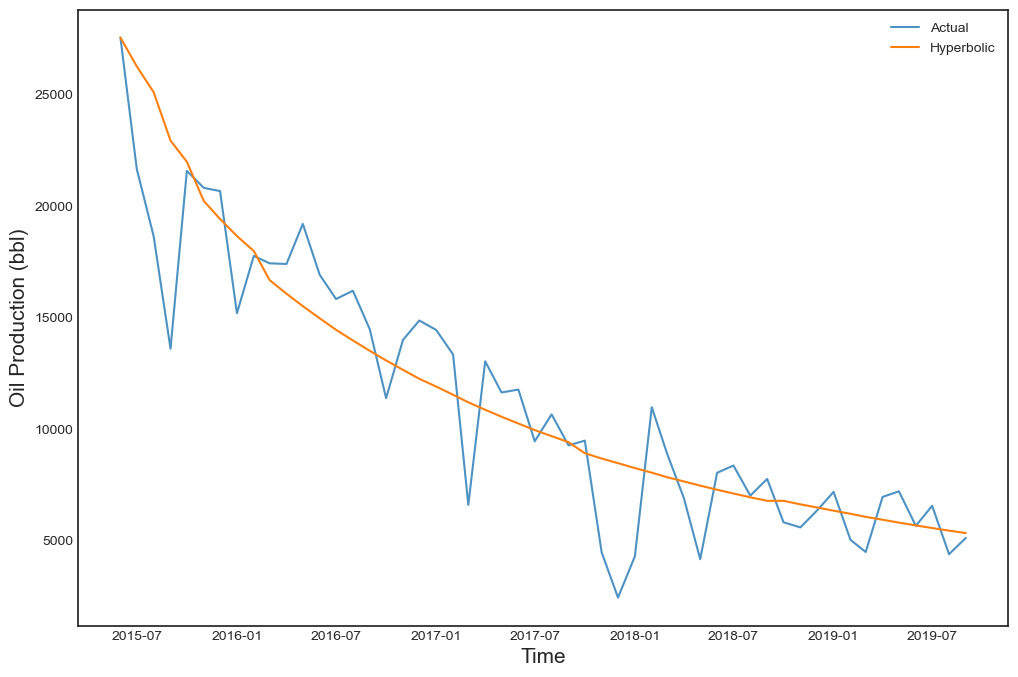

In [87]:
# hyperbolic forecast - plot
plt.plot(time, q_orig, alpha = 0.8, label='Actual')
plt.plot(time, forecast, label="Hyperbolic")
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Oil Production (bbl)', fontsize = 15)
plt.legend(loc='best')
plt.show()

In [89]:
rmse = sqrt(mean_squared_error(q_orig, forecast))
print("RMSE - Hyperbolic Method:", rmse)

RMSE - Hyperbolic Method: 2591.9276454267297


In [92]:
rmse_train = sqrt(mean_squared_error(q, pred_hyp))
print("Train RMSE", rmse_train)

Train RMSE 2905.158413445567


In [93]:
rmse_test = sqrt(mean_squared_error(q_test, pred_hyp2))
print("Test RMSE:", rmse_test)

Test RMSE: 989.2256022633607
